## Carga y Slicing de Datos

In [1]:
import numpy as np 
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib.animation import FuncAnimation

# Utiliza el estilo de gráficos de Seaborn incluso cuando se utiliza Matplotlib
sns.set()

# Se cargan los datos sobre predicción de precios de casas
Data = np.load('proyecto_training_data.npy')

# Dimensiones de los datos
filas, cols = Data.shape

# Se "shufflelean" los datos
rng = np.random.default_rng()
rng.shuffle(Data, axis=0)

# Límite para extraer los datos de entrenamiento (80%)
lim_sup_train = int(filas*0.8)

# Extracción de datos de entrenamiento (80%) y de validación (20%)
train_data = Data[0:lim_sup_train, :]
test_data = Data[lim_sup_train:filas, :]


## Análisis Exploratorio de los Datos

Cálculo de la media, valor máximo, valor mínimo, rango y desviación estándar de tanto X como Y.

In [2]:
# Medias para cada variable en el dataset 
# (nanmean ignora valores NaN)
medias = np.nanmean(Data, axis=0)

# Valor máximo y mínimo de cada variable
val_max = np.nanmax(Data, axis=0)
val_min = np.nanmin(Data, axis=0)

# Rango "pico a pico" de cada variable
rango = val_max - val_min

# Desviación estándar de cada variable
desvest = np.nanstd(Data, axis=0)

# Utilizado para evitar que Numpy utilice notación científica
np.set_printoptions(precision=3, suppress=True)

print("Medias:", np.around(medias, decimals=2))
print("Max:", val_max)
print("Min:", val_min)
print("Rango:", rango)
print("Desviación Est:", desvest)

Medias: [180921.2       6.1    1162.63      6.52   1971.27     70.05]
Max: [755000.     10.   4692.     14.   2010.    313.]
Min: [34900.     1.   334.     2.  1872.    21.]
Rango: [720100.      9.   4358.     12.    138.    292.]
Desviación Est: [79415.292     1.383   386.455     1.625    30.193    24.275]


Para cada variable en el dataset usar seaborn para graficar un histograma de la variable.

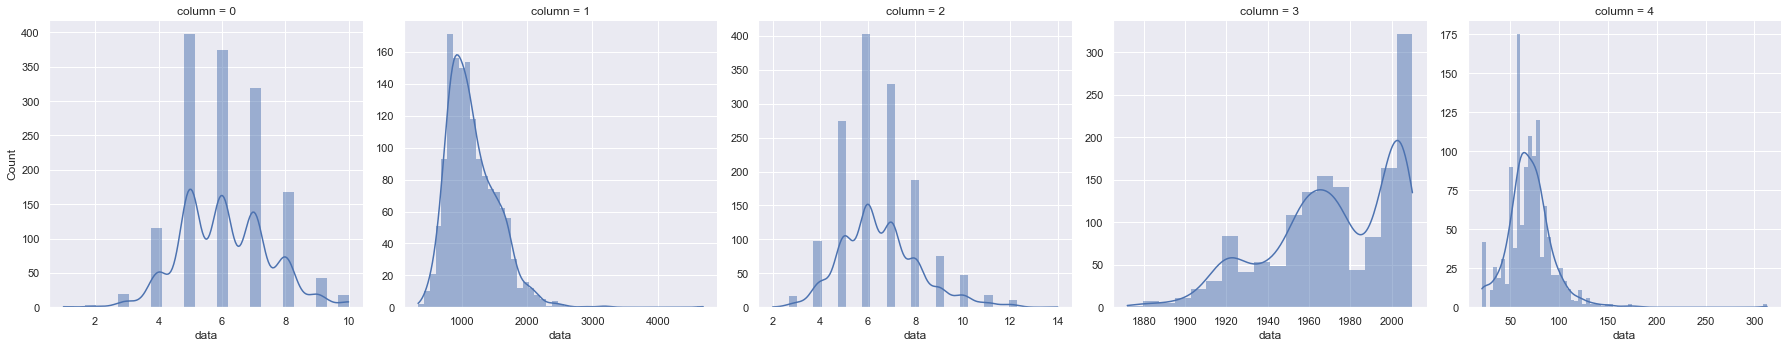

In [3]:
sns.set_theme()

# Variables independientes del dataset
VariablesInd = Data[:, 1:6]

# Aplana las 5 columnas de datos
FlatData = VariablesInd.flatten(order='F')

# Se crea un vector con números de 0 al número de columnas menos 1
#       Código: np.arange(VariablesInd.shape[1])
# Se repite cada número en el vector "para abajo" el número de filas
#       Código: np.repeat(num_cols, VariablesInd.shape[0])
Columns = np.repeat(np.arange(VariablesInd.shape[1]), VariablesInd.shape[0])

# Se crea un dataframe de pandas temporal
df = pd.DataFrame({"data": FlatData, "column": Columns})

# Creación del displot
# "sharey" es necesario para que no se compartan las escalas Y entre subplots
# "common_bins" es necesario para que no se compartan las escalas X entre subplots
g = sns.displot(data=df, 
                x="data", col="column", 
                kde=True, 
                facet_kws={"sharey": False, "sharex": False},
                common_bins=False)


## Correlación y Gráfica de X y Y

Gráfica de los puntos X y Y utilizando un scatter plot, además de la presentación del coeficiente de correlación entre ambas variables

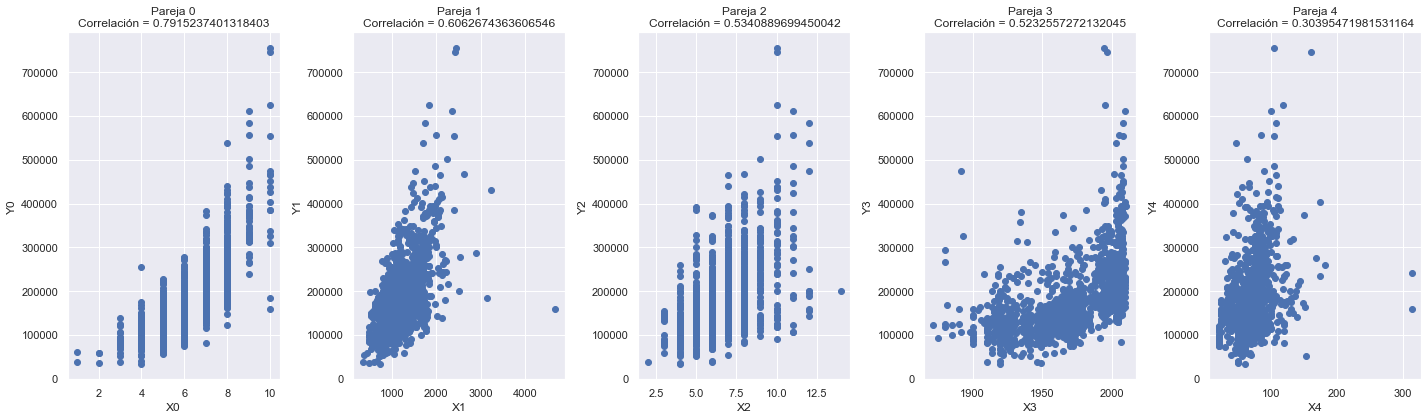

In [4]:
# Correlación de Pearson
def corr_pearson(X,Y):

    # Media de X y Y (Cada serie de valores es una columna nueva)
    MediaX = np.nanmean(X, axis=0)
    MediaY = np.nanmean(Y, axis=0)

    # Cálculo de la covarianza
    Numerador = np.nansum((X - MediaX)*(Y - MediaY), axis=0)
    Covarianza = Numerador / (X.shape[0] - 1)

    return Covarianza / (np.nanstd(X, axis=0) * np.nanstd(Y, axis=0))

X = Data[:,1:6]
Y = Data[:,0]

fig, axes = plt.subplots(1,5)
fig.set_size_inches(20,6)

for i in range(5):
    axes[i].scatter(X[:,i], Y)
    axes[i].set_xlabel(f"X{i}")
    axes[i].set_ylabel(f"Y{i}")
    axes[i].title.set_text(f"Pareja {i}\nCorrelación = {corr_pearson(X[:,i], Y)}")

# Para prevenir gráficas sobre-puestas
fig.tight_layout()


De acuerdo con lo observado en las gráficas y los coeficientes de correlación obtenidos, se podría llegar a establecer que la pareja que presenta mayor "potencial predictivo" utilizando un modelo lineal es la pareja 0 o aquella que corresponde a las primeras dos columnas de los datos cargados. 

## Función para Modelo de Regresión Lineal

Función para entrenar un modelo de regresión lineal de una variable con la forma y = mx + b

In [5]:
def train_linreg(X, Y, epochs=200, imprimir_error_cada=10, lr=0.001):

    # Se redimensionan los arrays para convertirlos en vectores columna
    X = np.reshape(X, (len(X), 1))
    Y = np.reshape(Y, (len(Y), 1))

    # Se le agrega una columna de unos
    X = np.append(X, np.ones(X.shape), axis=1)

    # Se inicializan los parámetros "m" y "b"
    # Se crea un vector fila para los parametros (Vector de 2X1)
    m = 0
    b = 0
    params = np.array([m, b])
    params = np.reshape(params, (len(params), 1))

    # Se almacena el primer modelo en un diccionario
    modelo = {}
    modelo[0] = params

    # Historial del error obtenido por epoch
    error_historial = np.zeros((epochs,1))

    # Código para las epochs
    for i in range(epochs):

        # Cálculo de yhat o la estimación de los valores de y
        yhat = np.dot(X, params)

        # Cálculo del error entre "y" y "yhat"
        error = np.nanmean((Y - yhat)**2) / 2

        # Se guarda el error actual en el historial
        error_historial[i] = error

        # Cálculo del gradiente del error con respecto a cada parámetro
        #   Elemento 0: Gradiente de m
        #   Elemento 1: Gradiente de b
        grad = np.nanmean((yhat - Y) * X, axis=0)
        grad = np.reshape(grad, (len(grad), 1))

        # Actualización de los parámetros del modelo
        params = params - lr * grad

        # Almacenamiento del modelo en la iteración actual en un diccionario
        modelo[i+1] = params


    return modelo, error_historial


Función que permita visualizar como cambia el error en el tiempo. Esta debe tomar como parámetro el vector de errores generados durante el entrenamiento y graficar en el eje "X" el número de iteración y en el eje "Y" el error para esa iteración

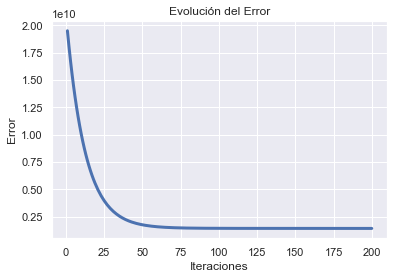

In [6]:
def visualizar_error(error):
    
    # Vector con el número de iteraciones (array que incrementa de 1 en 1)
    Iteraciones = np.arange(1, len(error)+1, 1)
    
    # Se grafica el desarrollo del error
    plt.plot(Iteraciones, error, linewidth=3)
    plt.xlabel("Iteraciones")
    plt.ylabel("Error")
    plt.title("Evolución del Error")

    return None

# =======================================
# Uso de la función 
# =======================================

X = Data[:,1]
Y = Data[:,0]

modelo, error = train_linreg(X,Y)
visualizar_error(error)
plt.show()


Función que permita visualizar como evoluciona el modelo entrenado en el tiempo. La función tomará la estructura de datos conteniendo el historial de modelos y un valor "n" que indica cada cuantas iteraciones se grafica el modelo resultante.

In [7]:
# Gráficas que cambian durante la animación
def animation_frame(i, modelo, x_model, line):
    
    # El plot puede continuar corriendo y se resetea al reiniciar
    if i == 0:
        y_model = 0*x_model + 0
        line.set_data(x_model, y_model)
        return line,

    # Parámetros del modelo de la iteración "i" actual
    params = modelo[i]
    m = params[0]
    b = params[1]

    # Cálculo de las "y's" correspondientes a la recta
    y_model = m * x_model + b
    
    # Se actualiza la recta
    line.set_ydata(y_model)

    return line, 

# Animación para visualizar la evolución de la recta acoplada
def visualizar_modelo(X,Y,modelo):

    %matplotlib ipympl

    fig, ax = plt.subplots()

    # Setup de las variables "globales" de la clase
    x_model = np.linspace(min(X), max(X), 1000)
    y_model = 0*x_model + 0

    # Setup del plot con el modelo
    line, = ax.plot(x_model, y_model, 'r')

    # Gráfica de los puntos con los datos (estática)
    ax.scatter(X,Y)
    ax.set_xlabel("X (Variable Independiente)")
    ax.set_ylabel("Precio")
    ax.set_title("Evolución de Modelo")

    anim = FuncAnimation(fig, func=animation_frame, frames=len(modelo), 
                        interval=10, repeat=False, blit=True, fargs=(modelo, x_model, line))

    return anim


# =======================================
# Uso de la función 
# =======================================

X = Data[:,1]
Y = Data[:,0]
modelo, error = train_linreg(X,Y)
animacion = visualizar_modelo(X, Y, modelo)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Claramente, esto no consiste de exactamente lo que se solicitaba en la guía de trabajo, ya que no grafica un cierto número de rectas en el mismo plot (algo  más sencillo de hacer). Sin embargo, considero que esta implementación resulta mucho más ordenada y comprensible en términos de su presentación. Debido a esto, obvié el parámetro "n" ya que ya no existe la necesidad de incluirlo.

## Entrenamiento de Modelos de Regresión Lineal

Utilizar las funciones previas para entrenar modelos de regresión lineal (y = mx + b) para cada una de las variables "X" elegidas. Basándose en las funciones para graficar creadas previamente, elegir el número de "epochs". 

### Variable 0: Overall Quality

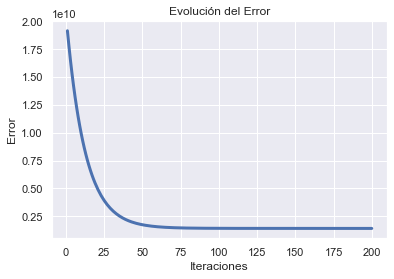

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [16]:
# Lista vacía con todos los modelos
modelos_custom = [None] * 5
errores_custom = [None] * 5

# Siempre colocar esta línea al inicio para que ambas gráficas se generen
%matplotlib inline

# Extracción de los datos
X = train_data[:,1]
Y = train_data[:,0]

# Generación de modelo
modelo, error = train_linreg(X,Y)

# Se almacenan los resultados en una lista
modelos_custom[0] = modelo
errores_custom[0] = error

# Visualización de error
plt.clf()
visualizar_error(error)
plt.show()

# Visualización de modelo
animacion = visualizar_modelo(X, Y, modelo)


### Variable 1: Pies Cuadrados del Primer Piso

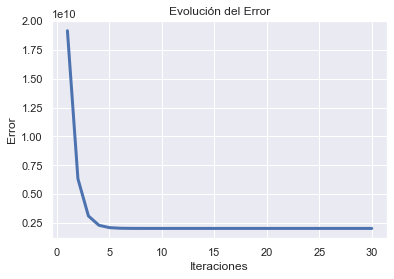

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [17]:
# Siempre colocar esta línea al inicio para que ambas gráficas se generen
%matplotlib inline

# Extracción de los datos
# Se escalan los valores de los ejes para evitar errores de overflow
X = train_data[:,2] 
Y = train_data[:,0]

# Generación de modelo
# El learning rate necesita ser así de bajo o se obtiene un error de overflow
modelo, error = train_linreg(X,Y, lr=0.000001, epochs=30)

# Se almacenan los resultados en una lista
modelos_custom[1] = modelo
errores_custom[1] = error

# Visualización de error
plt.clf()
visualizar_error(error)
plt.show()

# Visualización de modelo
animacion = visualizar_modelo(X, Y, modelo)

### Variable 2: Número total de Cuartos

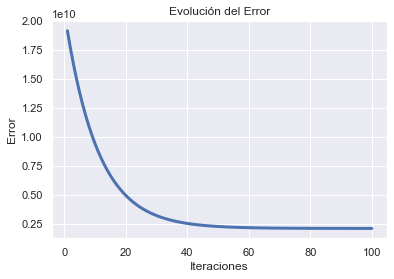

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [18]:
# Siempre colocar esta línea al inicio para que ambas gráficas se generen
%matplotlib inline

# Extracción de los datos
X = train_data[:,3]
Y = train_data[:,0]

# Generación de modelo
modelo, error = train_linreg(X,Y, epochs=100)

# Se almacenan los resultados en una lista
modelos_custom[2] = modelo
errores_custom[2] = error

# Visualización de error
plt.clf()
visualizar_error(error)
plt.show()

# Visualización de modelo
animacion = visualizar_modelo(X, Y, modelo)

### Variable 3: Fecha de la Construcción

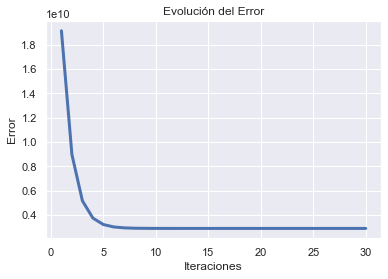

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
# Siempre colocar esta línea al inicio para que ambas gráficas se generen
%matplotlib inline

# Extracción de los datos
# Se re-escalan los ejes para evitar errores de overflow
X = train_data[:,4] 
Y = train_data[:,0]

# Generación de modelo
modelo, error = train_linreg(X,Y, lr=0.0000001, epochs=30)

# Se almacenan los resultados en una lista
modelos_custom[3] = modelo
errores_custom[3] = error

# Visualización de error
plt.clf()
visualizar_error(error)
plt.show()

# Visualización de modelo
animacion = visualizar_modelo(X, Y, modelo)

### Variable 4: Pies Lineales Conectados a la Propiedad

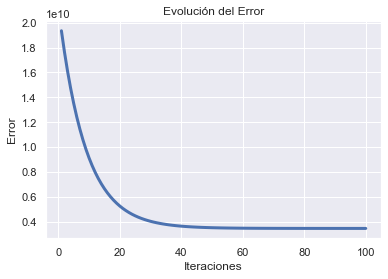

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [20]:
# Siempre colocar esta línea al inicio para que ambas gráficas se generen
%matplotlib inline

# Extracción de los datos
# Se re-escalan los ejes para evitar errores de overflow
X = train_data[:,5]
Y = train_data[:,0]

# Generación de modelo
modelo, error = train_linreg(X, Y, lr=0.00001, epochs=100)

# Se almacenan los resultados en una lista
modelos_custom[4] = modelo
errores_custom[4] = error

# Visualización de error
plt.clf()
visualizar_error(error)
plt.show()

# Visualización de modelo
animacion = visualizar_modelo(X, Y, modelo)

## Regresión Lineal con Scikit-Learn

Entrenar modelo de regresión empleando el paquete scikit-learn

In [21]:
modelos_skl = [None] * 5

for i in range(5):

    Y = train_data[:,0]
    X = train_data[:,i+1]

    # Se convierte a los vectores en arrays bidimensionales
    X = np.reshape(X, (len(X), 1))
    Y = np.reshape(Y, (len(Y), 1))

    # Se concatenan los datos en una matriz de dos columnas
    data_filtered = np.concatenate((Y,X), axis=1)

    # Se filtran los "NaNs"
    data_filtered = data_filtered[~np.isnan(data_filtered).any(axis=1)]

    # Se re-extraen las variables X y Y
    X = data_filtered[:,1]
    Y = data_filtered[:,0]

    # Se re-redimensionan las variables
    X = np.expand_dims(X, axis=1)
    Y = np.expand_dims(Y, axis=1)

    # Creación de modelo
    modelos_skl[i] = LinearRegression()
    modelos_skl[i].fit(X,Y)

## Función Predictiva

Crear una función que tome un vector con los valores para una variable X elegida y calcule 3 cosas:

- La predicción con el modelo entrenado manualmente
- La predicción con el modelo de scikit-learn
- La combinación o promedio de las dos anteriores

In [22]:
def predecir_reglin(X, modelo_manual, modelo_skl):
    
    # Nos aseguremos que el vector de X sea bidimensional
    if len(X.shape) < 2: 
        X = np.expand_dims(X, axis=1)

    # Se le agrega una columna al vector de X
    X_temp = np.append(X, np.ones(X.shape), axis=1)

    # Se calcula la predicción manual
    pred_manual = np.dot(X_temp, modelo_manual)

    # Se calcula la predicción con scikit
    pred_skl = modelo_skl.predict(X)

    # Cálculo del promedio de ambas predicciones
    preds = np.concatenate((pred_manual, pred_skl), axis=1)
    pred_prom = np.mean(preds, axis=1)

    return pred_manual, pred_skl, pred_prom


## Validación

Utilizando el 20% de los datos de validación, aplicamos los modelos predictivos para estimar la variable Y. Luego, usando los valores reales de "Y" calculamos el error de cada modelo. Para cada variable X elegida se debe: 

- Graficar el error de cada modelo para la variable X
- Concluir cuál modelo para la variable X es el mejor (error más bajo)

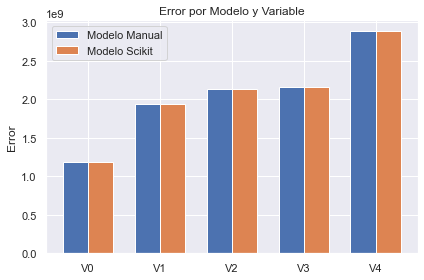

In [23]:
# Empleado para evitar que el notebook genere las figuras como un widget
%matplotlib inline

# Listas vacías con todos los errores generados por cada variable
error_manual = [None] * 5
error_skl = error_manual

# Labels para cada una de las barras del plot
# Una pareja de barras por cada variable (V0-4)
labels = ['V0', 'V1', 'V2', 'V3', 'V4']

# Posiciones de las barras sobre el eje X
bar_pos = np.arange(len(labels))

# Ancho de las barras
ancho = 0.35

# Creación de la gráfica
# Se utiliza "subplot" porque retorna la figura y los axes a la vez
fig, ax = plt.subplots()

for i in range(5):

    # ==================================
    # EXTRACCIÓN DE MODELOS
    # ==================================

    # Extracción de los parámetros finales "m" y "b"
    modelo_manual = modelos_custom[i][len(modelos_custom[i])-1]

    # Extracción del modelo entrenado por Scikit-Learn
    modelo_skl = modelos_skl[i]

    # ==================================
    # EXTRACCIÓN DE DATOS
    # ==================================

    # Datos de prueba a utilizar
    X = train_data[:, i+1]
    Y = train_data[:, 0]

    # Nos aseguramos que los vectores sean bidimensionales antes de concatenar
    X = np.expand_dims(X, axis=1)
    Y = np.expand_dims(Y, axis=1)

    # Se concatenan los datos en una matriz de dos columnas
    data_filtered = np.concatenate((Y,X), axis=1)

    # Se filtran los "NaNs"
    data_filtered = data_filtered[~np.isnan(data_filtered).any(axis=1)]

    # Se re-extraen las variables X y Y
    X = data_filtered[:,1]
    Y = data_filtered[:,0]

    # Nos aseguramos que los vectores sean bidimensionales
    X = np.expand_dims(X, axis=1)
    Y = np.expand_dims(Y, axis=1)

    # ==================================
    # PREDICCIÓN
    # ==================================

    # Generación de las predicciones empleando la función previa
    pred_manual, pred_skl, pred_prom = predecir_reglin(X, modelo_manual, modelo_skl)

    # Se calcula el error para cada una de las predicciones
    error_manual[i] = np.nanmean((Y - pred_manual)**2) / 2
    error_skl[i] = np.nanmean((Y - pred_skl)**2) / 2


# Graficación de todos los errores obtenidos
bars1 = ax.bar(bar_pos - ancho/2, error_manual, ancho, label='Modelo Manual')
bars2 = ax.bar(bar_pos + ancho/2, error_skl, ancho, label='Modelo Scikit')

# Settings de graficación
ax.set_ylabel('Error')
ax.set_title('Error por Modelo y Variable')
ax.set_xticks(bar_pos)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

De acuerdo a los resultados obtenidos, parece que no existen diferencias sustanciales entre el modelo creado manualmente y aquel creado con Scikit-Learn, al menos en términos de su error. Ambos modelos retornan virtualmente los mismos resultados, lo que significa que probablemente se debería de elegir el modelo que presente una mayor conveniencia para el usuario en términos de su implementación. Por esto, bajo este contexto, eligiría el modelo generado a partir de Scikit-Learn. 

Luego de esto, resulta interesante que los errores reflejen lo observado con los coeficientes de correlación: La variable 0 presenta el menor error y por lo tanto, presenta un mayor potencial para poder ser modelado por medio de una regresión lineal. Las variables restantes por el contrario, conforme menos se apegan a una tendencia lineal, mayor error presentan (en particular la variable 4). 